# Police Killings - Bias Against Women or Statistical Anomaly?
## Investigating the Likelihood of Being Unarmed for those Killed by Police
#### Data Source: https://mappingpoliceviolence.org/

In [38]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('C:/Users/u5677455/Dropbox/DataSciencePortfolio/PoliceKillings/data/MPVClean.xlsx')

In [39]:
# Printing out the variables
list(df.columns)

['name',
 'age',
 'gender',
 'race',
 'image',
 'date',
 'address',
 'city',
 'state',
 'zip',
 'county',
 'agency',
 'cause_of_death',
 'description',
 'justified',
 'charges',
 'link',
 'mental_illness',
 'armed',
 'victim_weapon',
 'threat_level',
 'fleeing',
 'camera',
 'WaPo ID (If included in WaPo database)']

In [40]:
print('Data ranges from ' + str(df.date.min())[0:4] + ' to ' + str(df.date.max())[0:4])

Data ranges from 2013 to 2017


#### Creating a separate dataframe with just the variables I'm considering at the moment

In [41]:
dfclean = df.loc[:,('age','gender','race','armed','victim_weapon','cause_of_death','description','mental_illness','threat_level','fleeing','justified')]
dfclean.head()

,age,gender,race,armed,victim_weapon,cause_of_death,description,mental_illness,threat_level,fleeing,justified
0,54,Female,White,Allegedly Armed,knife,Gunshot,"Around 10:35 p.m., officers responded to a cal...",Yes,other,Not fleeing,Pending investigation
1,49,Male,Black,Unclear,undetermined,Gunshot,"Rockford Police Officer Jaimie Cox, 30, was ki...",No,undetermined,Car,Pending investigation
2,31,Female,Hispanic,Vehicle,vehicle,Gunshot,Ruidoso police were dispatched to a residence ...,No,attack,Not fleeing,Pending investigation
3,Unknown,Male,White,Allegedly Armed,gun,Gunshot,"A couple was riding with an unidentified man, ...",Unknown,attack,Not fleeing,Pending investigation
4,56,Male,Asian,Allegedly Armed,knife,Gunshot,A Clarksville Police Department officer pulled...,No,attack,Not fleeing,Pending investigation


#### Creating binary variables for ease in analysis

In [42]:
dfclean['woman'] = (df.gender=='Female').astype(int)
dfclean['man'] = (df.gender=='Male').astype(int)
dfclean['white'] = (df.race=='White').astype(int)
dfclean['black'] = (df.race=='Black').astype(int)
dfclean['nonwhite'] = (df.race!='White').astype(int)

In [43]:
#Possible values of 'armed'
dfclean.armed.unique()

array(['Allegedly Armed', 'Unclear', 'Vehicle', 'Unarmed', nan], dtype=object)

In [44]:
# Define 'armed' as clearly armed
# Define 'unarmed' as clearly unarmed
# Vehicle and unclear are the other possible values
dfclean['armed'] = (df.armed=='Allegedly Armed').astype(int)
dfclean['unarmed'] = (df.armed=='Unarmed').astype(int)

In [45]:
# The 10 most common causes of death
df.groupby(['cause_of_death'])['cause_of_death'].count().sort_values(ascending=False)[0:10]

cause_of_death
Gunshot               4754
Vehicle                352
Taser                  186
Gunshot, Taser         178
Physical restraint      63
Medical Emergency       49
Unknown                 22
Beaten                  21
Asphyxiated             11
Physical Restraint       9
Name: cause_of_death, dtype: int64

#### Restrict to just cases where the intent to kill seems most likely: Beating and Gunshot
#### The goal is to exclude accidental or incidental deaths

In [46]:
dfclean['intentional'] = df.cause_of_death.str.contains('(Gunshot)|(Beat)').astype(int)
dfclean = dfclean.loc[dfclean.intentional==1,:]
dfclean.groupby(['cause_of_death'])['cause_of_death'].count()

C:\Users\u5677455\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


cause_of_death
Beaten                            21
Beating                            4
Gunshot                         4754
Gunshot, Stabbed                   1
Gunshot, Taser                   178
Gunshot, Taser, Pepper spray       1
Gunshot, Vehicle                   1
Taser, Beaten                      1
Name: cause_of_death, dtype: int64

#### Here I'm running a Logit which tells whether the probability of belonging to a certain group makes it statistically more likely for you to be unarmed conditional on you being intentionally killed by the police

In [47]:
from statsmodels.formula.api import logit
model = logit('unarmed ~ woman + black', dfclean).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.361331
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                unarmed   No. Observations:                 4961
Model:                          Logit   Df Residuals:                     4958
Method:                           MLE   Df Model:                            2
Date:                Thu, 16 Nov 2017   Pseudo R-squ.:                 0.01382
Time:                        14:15:00   Log-Likelihood:                -1792.6
converged:                       True   LL-Null:                       -1817.7
                                        LLR p-value:                 1.231e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1931      0.056    -39.259      0.000      -2.303      -2.084
woman          0.9100      0.

#### The findings here absolutely shocked me. Women are much more likely to be unarmed even compared with black individuals. The effect is statistically significant for both black and women.

Text(0,0.5,'Percent of Victims Unarmed')

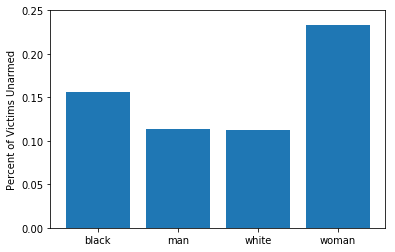

In [48]:
plotdata = dfclean.groupby(['unarmed']).sum()
plotdata = plotdata.loc[:,('black','woman','white','man')]
plotdata = plotdata.append(plotdata.sum(),ignore_index=True)
x = list(plotdata.columns)
y = list(plotdata.loc[1]/plotdata.loc[2])
plt.bar(x,y)
plt.axis(ymax=.25)
plt.ylabel('Percent of Victims Unarmed')

In [49]:
# raw count numbers for how many were killed while unarmed or otherwise for each group
dfclean.groupby(['unarmed'])['woman','man','white','black'].sum()

,woman,man,white,black
unarmed,,,,
0,194,4160,2023,1085
1,59,535,255,201


In [50]:
# probabilities of being unarmed when killed
plotdata.loc[1]/plotdata.loc[2]

black    0.156299
woman    0.233202
white    0.111940
man      0.113951
dtype: float64

#### This bar chart shows that the chance of being unarmed conditional on being intentionally killed is 23% for women compared to about 11% for men and about 16% for black. 
#### The difference between men and women is 12% while the difference between white and black is 5%. So if we are looking for patterns of injustice, women seem to stand out more than any other group.
#### Police killing unarmed women at this rate is difficult to rationalize because I'd expect an unarmed man to be more dangerous than an unarmed woman on average. So if the police are killing in reponse to feeling threatened, you'd expect the portion of unarmed women to be much lower, and this was my expectation coming in.

## So what's different about the encounters with women that could possibly explain this?

In [51]:
# Looking into mental illness commonality
df.groupby(['mental_illness'])['mental_illness'].count()

mental_illness
Drug or alcohol use     261
No                     3298
Unknown                1070
Unknown                   2
Yes                    1056
unknown                   1
yes                       1
Name: mental_illness, dtype: int64

In [52]:
# The most common weapons for the eventual victims
df.groupby(['victim_weapon','armed'])['victim_weapon'].count().sort_values(ascending=False)[0:10]

victim_weapon  armed          
gun            Allegedly Armed    1596
knife          Allegedly Armed     424
unarmed        Unarmed             355
vehicle        Vehicle             268
undetermined   Unclear             143
toy            Unarmed             108
passenger      Vehicle              88
machete        Allegedly Armed      24
sword          Allegedly Armed      11
baseball bat   Allegedly Armed       9
Name: victim_weapon, dtype: int64

In [53]:
# Correlation table
dfclean.corr()

,armed,woman,man,white,black,nonwhite,unarmed,intentional
armed,1.000000,-0.064697,0.061153,0.045424,-0.071508,-0.045424,-0.680636,NaN
woman,-0.064697,1.000000,-0.973910,0.058519,-0.040947,-0.058519,0.081021,NaN
man,0.061153,-0.973910,1.000000,-0.051819,0.040745,0.051819,-0.074836,NaN
white,0.045424,0.058519,-0.051819,1.000000,-0.545078,-1.000000,-0.022120,NaN
black,-0.071508,-0.040947,0.040745,-0.545078,1.000000,0.545078,0.066625,NaN
nonwhite,-0.045424,-0.058519,0.051819,-1.000000,0.545078,1.000000,0.022120,NaN
unarmed,-0.680636,0.081021,-0.074836,-0.022120,0.066625,0.022120,1.000000,NaN
intentional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Choose a random 10 descriptions of an incident where the victim was an unarmed woman and print out the description

In [54]:
fvictims = df.loc[(df['gender']=="Female") & (df['armed']=='Unarmed') & (df['cause_of_death']=='Gunshot'),'description']

for x in range(10):
    rando = np.random.randint(0,len(fvictims))
    print(fvictims[fvictims.index[rando]])
    print(str(fvictims.index[rando]) + '\n')


Police said Beaty threatened a man with a toy gun when they shot and killed her.
1909

Borden, who suffered from a number of mental illnesses and depression, shot and killed his wife, two children, mother-in-law and himself.
4517

The bodies of Capt. Rick Moore and Westminster City Clerk Amanda Jensen were found in Moore's apartment after police responded to a 911 call.
347

After a burglary and chase, passenger Ambrosia Fagre and driver Kadhar Bailey were shot and killed by police after their car allegedly hit a Maine State Police cruiser.
872

A South Gate police officer and his wife were found fatally shot at their Long Beach condo, and police said the double shooting was under investigation as a possible murder-suicide. Police were called to a possible domestic violence incident. The condo?s door was ajar, and inside, officers found Kyle Kurian, 25, and his wife, Greta Kurian, 22, with gunshot wounds in their upper torsos. Greta Kurian was pronounced dead at the scene. Her husband,

#### After spending a while reading through descriptions, it's clear that many of the 'unarmed' incidents are caused by fake guns like BB guns. That seems to affect both men and women. One thing that only affects women is that whenever an officer kills their wife/girlfriend, it shows up on this report as a police killing despite the fact that it's off-duty. This needs to be corrected for because it's almost certainly skewing the results.
#### The data is honestly pretty noisy with quite a few accidents where men are classified as women, victims who weren't shot but killed in an incident involving a shooting, etc. This will be difficult to correct, and I can just hope that the mistakes are random and uncorrelated to the unarmed stats I'm investigating. I have no reason so far to believe otherwise.
#### I haven't been able to think of a good way of controlling this (and I'm not sure it should be controlled for), but it's clear that many female victims are involved in the altercations because of their close relationship with a criminal. The girlfriend is in the passenger seat, boyfriend tries to ram police, police fire and hit the girlfriend. That sort of thing.

#### Here I'm going to further restrict the data by excluding murder in domestic violence cases. The particular words I'm using are  'wife', 'girlfriend', and 'mother' along with 'murder' appearing under the 'justified' variable. It's not perfect but better for sure. I'll see if this correction alleviates the discrepancy we're seeing.

In [56]:
# This is very tricky. On one hand I could just read through these and tag the ones that are clearly domestic violence, but then I'm ignoring all such deaths on the male and armed side of things, and there are too many of those to go through manually. I have to rely here on the tag 'murder' appearing under justified which isn't ideal since it takes a while for the courts to rule on cases like this.

# Generating description length since almost all cases of officer killing parter has extremely short description
dfclean['deslength'] = df.description.str.len()


dfclean['domesticViolence'] = (df.justified.str.contains('([Mm]urder)|(Unreported)|(Pending investigation)|(Accidental)')) & (df.description.str.contains('([Ww]ife)|([Gg]irlfriend)|([Mm]other)|([Bb]oyfriend)|([Hh]usband)') & (df.threat_level!='attack') & (df.gender=='Female') & (dfclean.deslength<400) & (df.armed!='Allegedly Armed'))

C:\Users\u5677455\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


In [57]:
# Number of victims of domestic violence killings by gender
# I'm clearly getting a bunch of cases where it wasn't the officer who killed his wife/girlfriend, as evidenced by all the male cases, but I think excluding those as well can still help paint this picture by making sure I'm not including things like officers killing their family
dfclean.groupby(['gender'])['domesticViolence'].sum()

gender
Female         17.0
Male            0.0
Transgender     0.0
Unknown         0.0
Name: domesticViolence, dtype: float64

#### Here I'm printing out a random 10 cases just to be convinced that I'm indeed only identifying domestic violence cases where the officer kills his significant other. This seems to do very well. I have a couple false positives and there are most certainly a few false negatives but this is at least a good start in removing cases where an officer kills his sig other.

In [58]:
domvio = dfclean.loc[dfclean.domesticViolence==1,:]

for x in range(10):
    rando = np.random.randint(0,len(domvio))
    print(domvio.loc[domvio.index[rando],'description'])
    print('Victim gender: ' + str(domvio.loc[domvio.index[rando],'gender']))
    print('Justified: ' + str(domvio.loc[domvio.index[rando],'justified']))
    print('Fleeing: ' + str(domvio.loc[domvio.index[rando],'fleeing']))
    print('Threat level: ' + str(domvio.loc[domvio.index[rando],'threat_level']))
    print('Victim weapon: ' + str(domvio.loc[domvio.index[rando],'victim_weapon']))
    print('Row number: ' + str(domvio.index[rando]) + '\n')

Granville County Sheriff's Deputy Jeremy S. Pearce, and his wife, Rebecka J. Pearce, were found shot dead at a house in Fuquay-Varina in a case of domestic violence.
Victim gender: Female
Justified: Murder/suicide
Fleeing: Not fleeing
Threat level: other
Victim weapon: unarmed
Row number: 1177

Suspect Marcas McGowan abducted young Harris away from her mother, from a home the three shared, and led police on a high-speed chase that ended with him wounded and Harris in the back seat, shot to death. Slow and loathe to make any admissions, police and prosecutor reports have gradually revealed that she died from police bullets -- but he has been charged for her murder.
Victim gender: Female
Justified: Unreported
Fleeing: nan
Threat level: nan
Victim weapon: nan
Row number: 3930

Borden, who suffered from a number of mental illnesses and depression, shot and killed his wife, two children, mother-in-law and himself.
Victim gender: Female
Justified: Murder/suicide
Fleeing: nan
Threat level: na

In [59]:
model = logit('unarmed ~ woman + black', dfclean.loc[dfclean.domesticViolence==0,:]).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.357493
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                unarmed   No. Observations:                 4944
Model:                          Logit   Df Residuals:                     4941
Method:                           MLE   Df Model:                            2
Date:                Thu, 16 Nov 2017   Pseudo R-squ.:                0.008951
Time:                        14:15:36   Log-Likelihood:                -1767.4
converged:                       True   LL-Null:                       -1783.4
                                        LLR p-value:                 1.168e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1926      0.056    -39.166      0.000      -2.302      -2.083
woman          0.5987      0.

Text(0,0.5,'Percent of Victims Unarmed')

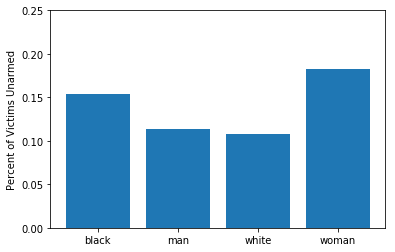

In [60]:
plotdata = dfclean.loc[dfclean.domesticViolence==0,:].groupby(['unarmed']).sum()
plotdata = plotdata.loc[:,('black','woman','white','man')]
plotdata = plotdata.append(plotdata.sum(),ignore_index=True)
x = list(plotdata.columns)
y = list(plotdata.loc[1]/plotdata.loc[2])
plt.bar(x,y)
plt.axis(ymax=.25)
plt.ylabel('Percent of Victims Unarmed')

In [61]:
dfclean.loc[dfclean.domesticViolence==0,:].groupby(['unarmed']).sum()

,armed,woman,man,white,black,nonwhite,intentional,deslength,domesticViolence
unarmed,,,,,,,,,
0,3835,193,4160,2023,1085,2343,4366,1166405.0,False
1,0,43,535,244,197,334,578,165667.0,False


#### Looks like there's still a large discrepancy where women are more likely to be unarmed. 

## Correcting for Fake Guns
#### If you think that things like BB guns don't exactly qualify a case as 'unarmed' then I'm going to exclude 'fake gun' cases and see if this changes things.

In [62]:
dfclean['fakegun'] = (dfclean.victim_weapon=='toy').astype(int)
temp = dfclean.loc[dfclean.victim_weapon=='toy','description']

#### It looks like the fake gun phenomena is common for both genders

In [63]:
dfclean.groupby(['gender'])['fakegun'].sum()

gender
Female           7
Male           101
Transgender      0
Unknown          0
Name: fakegun, dtype: int32

In [64]:
# Here I'm changing the 'armed' status to 'unclear' for the toy gun scenario
dfclean.loc[dfclean.fakegun==1,'unarmed'] = 0

Text(0,0.5,'Percent of Victims Unarmed')

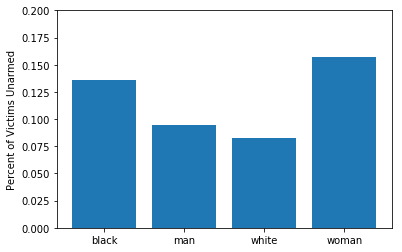

In [65]:
plotdata = dfclean.loc[(dfclean.domesticViolence==0) & (dfclean.fakegun==0),:].groupby(['unarmed']).sum()
plotdata = plotdata.loc[:,('black','woman','white','man')]
plotdata = plotdata.append(plotdata.sum(),ignore_index=True)
x = list(plotdata.columns)
y = list(plotdata.loc[1]/plotdata.loc[2])
plt.bar(x,y)
plt.axis(ymax=.20)
plt.ylabel('Percent of Victims Unarmed')

In [66]:
print('Percent increase in risk for black over white: ' + str(np.around(y[0]*100/y[2] - 100)) + '%\n' + 'Percent increase in risk for female over male: ' + str(np.around(y[1]*100/y[3] - 100)) + '%')

Percent increase in risk for black over white: 65.0%
Percent increase in risk for female over male: 66.0%


In [67]:
model = logit('unarmed ~ woman + black',dfclean.loc[(dfclean.domesticViolence==0) & (dfclean.fakegun==0),:]).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.314969
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                unarmed   No. Observations:                 4836
Model:                          Logit   Df Residuals:                     4833
Method:                           MLE   Df Model:                            2
Date:                Thu, 16 Nov 2017   Pseudo R-squ.:                 0.01220
Time:                        14:15:43   Log-Likelihood:                -1523.2
converged:                       True   LL-Null:                       -1542.0
                                        LLR p-value:                 6.739e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4387      0.063    -38.994      0.000      -2.561      -2.316
woman          0.6419      0.

#### Women are still the most at-risk group, but it's not quite as drastic as before

## Mentally impaired whether through drugs or illness

In [68]:
dfclean.loc[(dfclean.domesticViolence==0) & (dfclean.fakegun==0),:].groupby(['mental_illness']).sum()

,armed,woman,man,white,black,nonwhite,unarmed,intentional,deslength,domesticViolence,fakegun
mental_illness,,,,,,,,,,,
Drug or alcohol use,126,6,179,111,26,74,32,185,57227.0,False,0
No,2162,103,2679,1105,861,1683,276,2788,741293.0,False,0
Unknown,726,48,865,435,218,481,87,916,233027.0,False,0
Unknown,1,0,1,1,0,0,0,1,354.0,False,0
Yes,819,72,868,551,151,393,74,944,270009.0,False,0
unknown,1,0,1,1,0,0,0,1,76.0,False,0
yes,0,0,1,1,0,0,1,1,NaN,False,0


In [69]:
#mentally impaired
dfclean['mentally_impaired'] = ((dfclean.mental_illness=='Yes') | (dfclean.mental_illness=='Drug or alcohol use')).astype(int)

#interaction btw woman and impaired
dfclean['mi_woman'] = (dfclean.mentally_impaired)*(dfclean.woman)

#interaction btw black and impaired
dfclean['mi_black'] = (dfclean.mentally_impaired)*(dfclean.black)

#interact woman and black
dfclean['woman_black'] = (dfclean.woman)*(dfclean.black)

df_nofake_novio_int = dfclean.loc[(dfclean.domesticViolence==0) & (dfclean.fakegun==0),:]
model = logit('unarmed ~ woman + black + mentally_impaired + mi_woman + mi_black',df_nofake_novio_int).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.313377
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                unarmed   No. Observations:                 4836
Model:                          Logit   Df Residuals:                     4830
Method:                           MLE   Df Model:                            5
Date:                Thu, 16 Nov 2017   Pseudo R-squ.:                 0.01720
Time:                        14:15:44   Log-Likelihood:                -1515.5
converged:                       True   LL-Null:                       -1542.0
                                        LLR p-value:                 3.317e-10
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.4366      0.073    -33.586      0.000      -2.579      -2.294
woman   

#### According to this, 1) being mentally impaired is tied to a decrease in the likelihood of a woman being unarmed when killed, and 2) being mentally impaired is tied to an increase in the likelihood of a black person being unarmed when killed. So differences in mental impairment isn't a way to explain either factor since the non-interaction coefficients are still significant for both 'woman' and 'black'.

In [70]:
model = logit('unarmed ~ woman + black + woman_black',df_nofake_novio_int).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.314862
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                unarmed   No. Observations:                 4836
Model:                          Logit   Df Residuals:                     4832
Method:                           MLE   Df Model:                            3
Date:                Thu, 16 Nov 2017   Pseudo R-squ.:                 0.01254
Time:                        14:15:44   Log-Likelihood:                -1522.7
converged:                       True   LL-Null:                       -1542.0
                                        LLR p-value:                 2.043e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.4478      0.063    -38.588      0.000      -2.572      -2.323
woman           0.7462    

#### While woman and black are both high risk groups, being a black woman isn't as worse of compared to nonblack women as the comparison between black and nonblack men. Adding this factor brings out the raw 'black' and 'woman' coefficients even more though, suggesting that both black men and nonblack women are even more at risk than the previous evidence has shown. To be clear, being a black woman is still the riskiest group and getting the true coefficient for black women would be ( .93 + .59 - .49 = 1.03). The negative coefficient just says that the relationship isn't strictly additive for woman and black.